## **GOAL**
We verify that, focusing on topics like gun control and minorities discrimination, users' debate is dominated by anti-trump ideology.

We develop our analysis building debates network and detecting communities.

### **NETWORK ANALYSIS**
We use the model to infer the orientation of the comments for each sociopolitical topic.

The data has the format 'id,author,link_id,parent_id,content,created'. Specifically, *id* is the id of the comment, *link_id* is the submission ID that the comment belongs to, *parent_id* is the ID of the parent comment (prefixed with t1_); If it is a top-level comment, this returns the submission ID instead (prefixed with t3_).

For each comment, we want the predictions of the model ranging from 0 to 1, where 1 means that the post aligns with pro-Trump ideologies and 0 with anti-Trump ideologies.

For each user u belonging to a specific topic, we compute its 'Leaning Score', Lu, as the average value of the leaning of its posts (sum of predictions divided by number of posts).

We define, for each topic, a users' debate network.
Each node in the network represents a user, and a link between two users exists if one responds to a comment of the other (if a user *b* has replied to a comment of *a*, in the dataset the *parent_id* of *b*'s comment will be equal to the id of *a*'s comment, and so we can trace the links).

The weight of each link represents the total number of comments exchanged between two users. Furthermore, we label users (i.e. nodes) with their leaning score Lu.
To do so, we discretize these leanings into three ranges:

Anti-Trump if Lu ≤ 0.3;

Pro-Trump if Lu ≥ 0.7;

while Neutral if 0.3 < Lu < 0.7.

### **COMMUNITY DETECTION**
We conduct a labelled community detection analysis.

Given a network describing user interactions centred on a controversial topic, we define an echo chamber as a subset of the network's nodes (users) that share the same ideology and tend to have dense connections primarily within the same group.

We exploit the modularity score to incrementally update community membership. The update is then weighted in terms of Cluster Purity, another function designed to capture the ideological cohesion of a community.

To get a clearer idea, we define:

Modularity as a quality score that measures the strength of the division of a network into modules;

Purity as the product of the frequencies of the most frequent labels carried by community's nodes;

Conductance as the fraction of the total volume of links pointing outside the community.

We decide to determine the extent to which a community qualifies as an echo chamber based on Purity and Conductance.

We set the purity score ≤ 0.7 to ensure that most echo chamber users share the same ideological label.
Meanwhile, for Conductance, we set a threshold of 0.5 for
to ensure that more than half of the total edges remain within the community boundaries.

### **SET UP THE ENVIRONMENT**

In [ ]:
!pip install --upgrade tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 37.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 50.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 44.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.7/347.7 kB 19.5 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully uninstalled h5py-3.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Successfully uninstalled tensorboard-2.15.2
  Attempting uninstall: keras
    Fo

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import tensorflow as tf
import pickle
import community as community_louvain
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **LOAD THE TRAINED MODEL, TOKENIZER AND EMBEDDING MATRIX**

Ensure new data is processed as data used for training

In [ ]:
# Path of saved files
model_path = '/content/drive/My Drive/new/model_lstm.keras'
tokenizer_path = '/content/drive/My Drive/new/tokenizer.pickle'
embedding_matrix_path = '/content/drive/My Drive/new/embedding_matrix.npy'

# Load the model
model = tf.keras.models.load_model(model_path)

# Load the tokenizer
with open(tokenizer_path, 'rb') as handle:
    tokenizer = pickle.load(handle)

# Load embedding matrix
embedding_matrix = np.load(embedding_matrix_path)

print("Model, Tokenizer and Embedding Matrix successfully loaded")
model.summary()

Model, Tokenizer and Embedding Matrix successfully loaded


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 238)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 238, 200)            │       4,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 238, 128)            │         168,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 238, 128)            │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 238, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 238, 128)            │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 238, 128)            │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 238, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 96)                  │           6,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 96)                  │             384 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 96)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,089,701 (19.42 MB)

 Trainable params: 362,913 (1.38 MB)

 Non-trainable params: 4,000,960 (15.26 MB)

 Optimizer params: 725,828 (2.77 MB)

### **LOAD AND PROCESS SOCIOPOLITICAL DATA**

In [ ]:
# Paths of topics' files
guncontrol_path = '/content/drive/My Drive/wsa/collected_data_topics/guncontrol_comments.csv'
minority_path = '/content/drive/My Drive/wsa/collected_data_topics/minority_comments.csv'

# Load
guncontrol_comments = pd.read_csv(guncontrol_path)
minority_comments = pd.read_csv(minority_path)


In [ ]:
def preprocess_data(data):

    # remove users whose account has been deleted
    data = data[data['author'] != 'deleted']
    #data.reset_index(drop=True, inplace=True)  # Reset index after filtering

    # Tokenization
    texts = data['content'].astype(str)  # Ensure string format
    sequences = tokenizer.texts_to_sequences(texts)

    # Padding of sequences
    data_padded = pad_sequences(sequences, maxlen=238)  # max len used during training

    return data_padded

# Process data for inference
guncontrol_data = preprocess_data(guncontrol_comments)
minority_data = preprocess_data(minority_comments)

print("Data ready for inference")

Data ready for inference


### **INFERENCE**

In [ ]:
def predict_and_calculate_scores(data, comments_df):
    # Inference
    predictions = model.predict(data)

    # Add predictions to original df
    comments_df['prediction'] = predictions.flatten()

    # Compute Leaning_score for each user
    leaning_scores = comments_df.groupby('author')['prediction'].mean().reset_index()
    leaning_scores.columns = ['author', 'Leaning_score']

    return leaning_scores

# Comppute leaning scores for each dataset
guncontrol_scores = predict_and_calculate_scores(guncontrol_data, guncontrol_comments)
minority_scores = predict_and_calculate_scores(minority_data, minority_comments)

print("Leaning scores for each topic:")
print('\n')
print("Gun Control:", guncontrol_scores.head())
print('\n')
print("Minority Discrimination:", minority_scores.head())

1867/1867 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step
983/983 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step
Leaning scores for each topic:


Gun Control:                  author  Leaning_score
0  -------------------c       0.642815
1        -----Kyle-----       0.308444
2    -----iMartijn-----       0.500361
3             ---TwT---       0.012305
4              --Edog--       0.302117


Minority Discrimination:                  author  Leaning_score
0      ----Maverick----       0.081540
1         --Ok_Boomer--       0.309884
2  --WorldStarPlatinum-       0.218230
3              --lily--       0.227529
4      --little_witch--       0.121314


Leaning Scores distribution Gun Control:


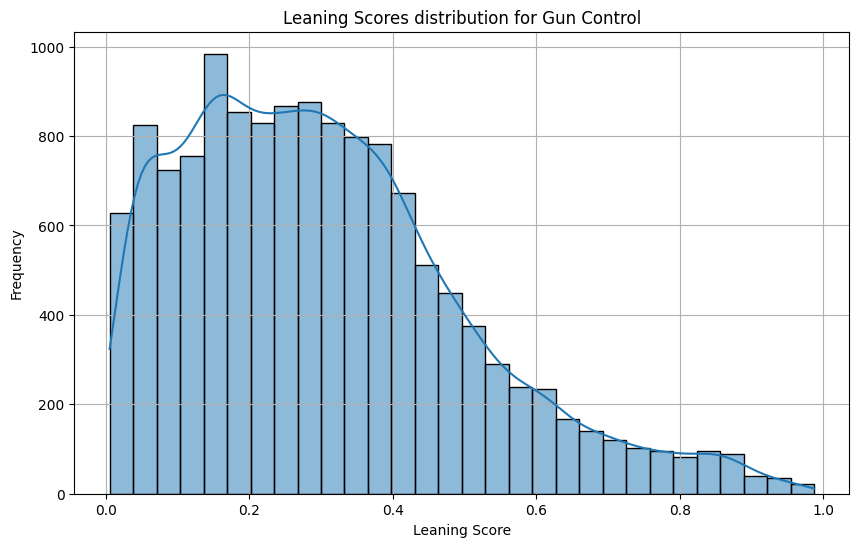



Leaning Scores distribution Minority Discrimination:


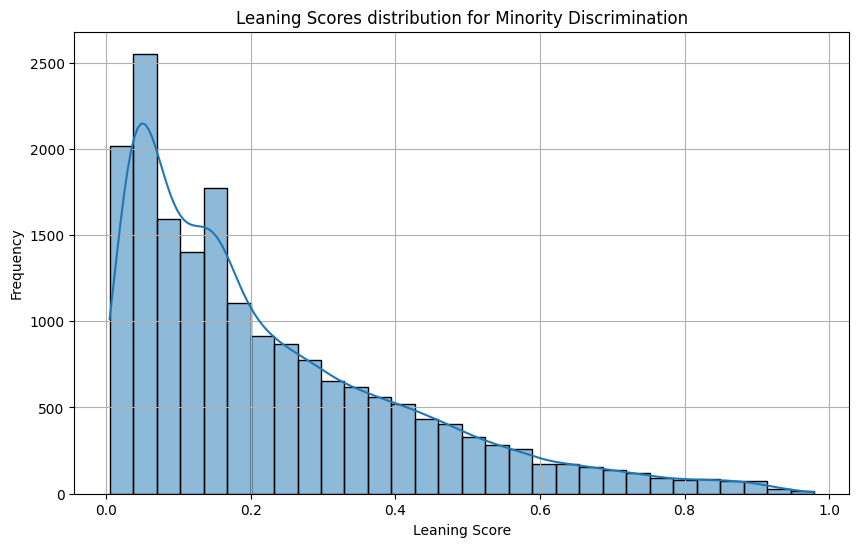

In [ ]:
def plot_leaning_scores(scores, title):
    plt.figure(figsize=(10, 6))
    sns.histplot(scores['Leaning_score'], kde=True, bins=30)
    plt.title(f'Leaning Scores distribution for {title}')
    plt.xlabel('Leaning Score')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

# Show for each topic
print('Leaning Scores distribution Gun Control:')
plot_leaning_scores(guncontrol_scores, "Gun Control")
print('\n')
print('Leaning Scores distribution Minority Discrimination:')
plot_leaning_scores(minority_scores, "Minority Discrimination")


### **BUILD NETWORKS**

In [ ]:
def build_network(comments_df, scores_df):
    # Initialize an undirected graph
    G = nx.Graph()

    # Define color based on Leaning_score thresholds
    def get_node_color(score):
        if score <= 0.3:
            return 'blue'  # Anti-Trump
        elif score >= 0.7:
            return 'red'  # Pro-Trump
        else:
            return 'gray'  # Neutral

    # Add nodes with attributes Leaning_score and color
    scores_dict = scores_df.set_index('author')['Leaning_score'].to_dict()
    for author, score in scores_dict.items():
        color = get_node_color(score)
        if score <= 0.3:
            label = 'Anti-Trump'
        elif score >= 0.7:
            label = 'Pro-Trump'
        else:
            label = 'Neutral'
        G.add_node(author, Leaning_score=score, label=label, color=color)

    # Add edges based on interactions
    for idx, row in comments_df.iterrows():
        if row['parent_id'].startswith('t1_'):  # if it's a comment response
            parent_id = row['parent_id'][3:]  # extract the ID
            parent_author_entries = comments_df.loc[comments_df['id'] == parent_id, 'author'].values
            if parent_author_entries.size > 0:
                parent_author = parent_author_entries[0]
                if parent_author in G.nodes and row['author'] in G.nodes:
                    # Check if an edge already exists, increment weight if it does, or add a new edge with weight 1
                    if G.has_edge(row['author'], parent_author):
                        G[row['author']][parent_author]['weight'] += 1
                    else:
                        G.add_edge(row['author'], parent_author, weight=1)

    return G


# Build network for each topic
guncontrol_network = build_network(guncontrol_comments, guncontrol_scores)
minority_network = build_network(minority_comments, minority_scores)

### **VISUALIZATION**
We try to show the networks using spring layout, a force-directed graph drawing algorithm which allow to draw graphs in an aesthetically pleasing way.
However, since we have a big graph, the result is still unreadable.
We show the result only for one topic, and then use Gephi tool for a better visualization

In [ ]:
# Mapping
color_map = {
    'Anti-Trump': 'blue',
    'Pro-Trump': 'red',
    'Neutral': 'gray'
}

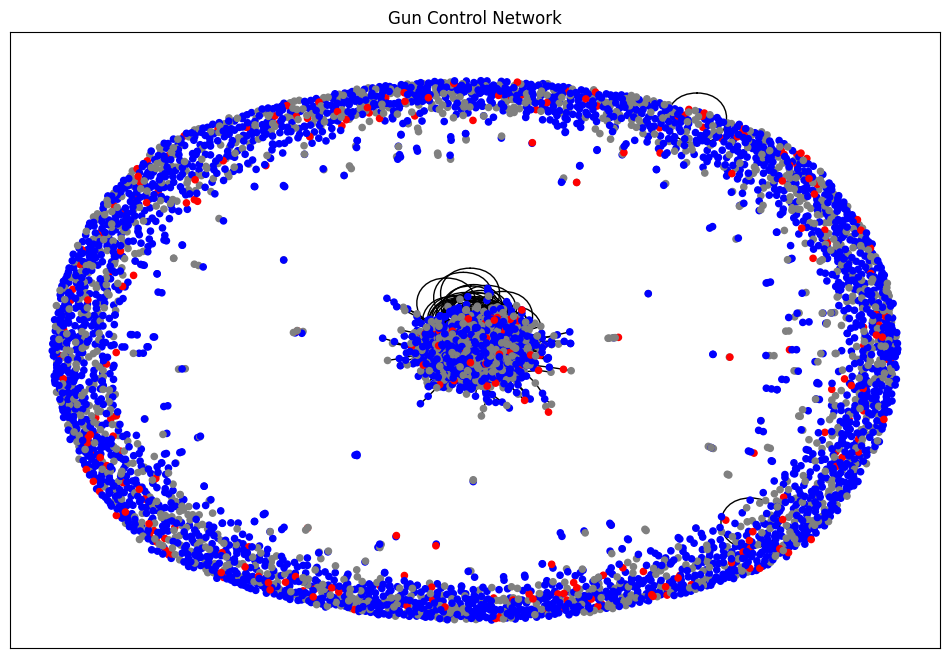

In [ ]:
# Show the network
def visualize_network(G, title):
    pos = nx.spring_layout(G, seed=42)  # Posizione dei nodi
    plt.figure(figsize=(12, 8))
    node_colors = [color_map[data['label']] for _, data in G.nodes(data=True)]
    nx.draw_networkx(G, pos, node_size=20, with_labels=False, node_color=node_colors)
    plt.title(title)
    plt.show()


visualize_network(guncontrol_network, "Gun Control Network")

#visualize_network(minority_network, "Minority Discrimination Network")

The nodes on the borders with few or no connections mirror somewhat the way debates on social networks work. These are users, perhaps less active, who have left isolated comments that have not received responses. This is a typical pattern when thinking about social discussions where there are many comments that remain unanswered.

### **SAVE FILES TO PROCESS WITH GEPHI**

In [ ]:
base_path = '/content/drive/My Drive/new/'

# Save GEXF files
nx.write_gexf(guncontrol_network, base_path + "guncontrol_network.gexf")
nx.write_gexf(minority_network, base_path + "minority_network.gexf")

### **NETWORK ANALYSIS**

#### **GENERAL STATISTICS**

In [ ]:
# Function to calculate network statistics
def calculate_network_metrics(network):
    number_of_nodes = network.number_of_nodes()
    number_of_edges = network.number_of_edges()
    density = nx.density(network)
    pro_trump = sum(1 for _, node_data in network.nodes(data=True) if node_data['label'] == 'Pro-Trump')
    anti_trump = sum(1 for _, node_data in network.nodes(data=True) if node_data['label'] == 'Anti-Trump')
    neutral = sum(1 for _, node_data in network.nodes(data=True) if node_data['label'] == 'Neutral')
    return number_of_nodes, number_of_edges, density, pro_trump, anti_trump, neutral

# Calculate metrics for each network
gun_metrics = calculate_network_metrics(guncontrol_network)
min_metrics = calculate_network_metrics(minority_network)

In [ ]:
# Create the final DataFrame
data = {
    "Topic": ["Gun Control", "Minorities Discrimination"],
    "# Nodes": [gun_metrics[0], min_metrics[0]],
    "# Edges": [gun_metrics[1], min_metrics[1]],
    "Density": [gun_metrics[2], min_metrics[2]],
    "# Pro-Trump": [gun_metrics[3], min_metrics[3]],
    "# Anti-Trump": [gun_metrics[4], min_metrics[4]],
    "# Neutral": [gun_metrics[5], min_metrics[5]]
}

final_table = pd.DataFrame(data)
print(final_table)

                       Topic  # Nodes  # Edges   Density  # Pro-Trump  \
0                Gun Control    13505    21348  0.000234          650   
1  Minorities Discrimination    18247     9744  0.000059          638   

   # Anti-Trump  # Neutral  
0          7344       5511  
1         13062       4547  


#### **CENTRALITY MEASURES**
We use centrality measures to identify the most influential authors in the network.

**Degree Centrality:** Directly measures the number of connections a node has with other nodes. It is useful in contexts where direct interactions indicate influence.

**Betweenness Centrality:** Measures the frequency with which a node appears on the shortest paths between other nodes. This indicates a node's power to control the flow of information in the network.

**Closeness Centrality:** Indicates how quickly information can spread from a given node to other nodes in the network.

In [ ]:
def get_top_centrality_measures_by_group(network, top_n=15):
    # Calculate centrality measures for the network
    degree_centr = nx.degree_centrality(network)
    betweenness_centr = nx.betweenness_centrality(network)
    closeness_centr = nx.closeness_centrality(network)

    results = {}  # To store dataframes for each type and group

    # Prepare visualization for each political group and each centrality measure
    for group in ['Pro-Trump', 'Anti-Trump']:
        filtered_nodes = {node for node, data in network.nodes(data=True) if data['label'] == group}

        # Prepare data for each centrality measure
        for centrality_type, centrality_data in zip(
            ["Degree Centrality", "Betweenness Centrality", "Closeness Centrality"],
            [degree_centr, betweenness_centr, closeness_centr]):

            # Build the DataFrame for the current centrality type
            group_data = [{
                "Author": node,
                centrality_type: centrality_data[node]
            } for node in filtered_nodes]

            df = pd.DataFrame(group_data)

            # Sort the DataFrame by the current centrality and select the top_n results
            df = df.sort_values(by=centrality_type, ascending=False).head(top_n)

            # Store DataFrame in results
            key = f"{group} {centrality_type}"
            results[key] = df

    return results

# Get top centrality measures for each group for guncontrol
results = get_top_centrality_measures_by_group(guncontrol_network)
for key, df in results.items():
    print(f"\nTop 15 {key}:")
    print(df.to_string(index=False))


Top 15 Pro-Trump Degree Centrality:
           Author  Degree Centrality
PineyWithAWalther           0.001407
         j-pender           0.001111
  Galgenvogel1993           0.000889
       purtymouth           0.000741
        n0manarmy           0.000741
    whetherman013           0.000666
     JamesIsSoPro           0.000666
       marckshark           0.000592
   Franticalmond2           0.000518
      Mini-Marine           0.000518
    ShotgunPumper           0.000518
      r1938595921           0.000518
     AKARoyRogers           0.000444
           Cronyx           0.000370
          wbbarth           0.000370

Top 15 Pro-Trump Betweenness Centrality:
           Author  Betweenness Centrality
PineyWithAWalther                0.000861
         j-pender                0.000739
   thoraismybirch                0.000732
       purtymouth                0.000671
          Mal5341                0.000462
     JamesIsSoPro                0.000388
  MackofallTrades                0.

In [ ]:
print_top_centrality_measures_by_group(minority_network)


Top 15 Pro-Trump influencers based on Degree Centrality:
             Author  Degree Centrality
    The-Truth-Fairy           0.001425
       MatureUser69           0.000329
             niliti           0.000274
  lubedupkneeplesse           0.000274
Squealing_Squirrels           0.000274
          shook_one           0.000274
             sylbug           0.000274
       photophysics           0.000274
            pablo95           0.000219
          naeshelle           0.000219
          parkmeeae           0.000219
         roybringus           0.000219
   MaximumEffort433           0.000219
      EightyMercury           0.000219
        anarckissed           0.000219

Top 15 Pro-Trump influencers based on Betweenness Centrality:
          Author  Betweenness Centrality
 The-Truth-Fairy                0.003190
           Cforq                0.000747
          niliti                0.000741
      Sarkavonsy                0.000693
       parkmeeae                0.000541
         

#### **ASSORTATIVITY**
Assortativity is a measure that quantifies the degree to which nodes in a network tend to be connected to other nodes with similar characteristics. It helps us understand the level of homophily or preference for connections between nodes with similar attributes in the network

In [ ]:
def print_assortativity(network):
    label_assortativity = nx.attribute_assortativity_coefficient(network, 'label')
    print("Label Assortativity Coefficient:", f"{label_assortativity:3.1f}")

print('GUN CONTROL')
print_assortativity(guncontrol_network)

GUN CONTROL
Label Assortativity Coefficient: 0.1


In [ ]:
print('MINORITIES DISCRIMINATION')
print_assortativity(minority_network)

MINORITIES DISCRIMINATION
Label Assortativity Coefficient: 0.2


#### **EDGE BETWEENNESS**
Analysing edge betweenness can provide valuable information on how nodes and links within your network act as bridges or gateways for the flow of information between different political communities.

The edge betweenness centrality of a link in a network measures the number of times a link is used in the shortest walks between all pairs of nodes. A high value of edge betweenness in a link indicates that this link is crucial to the flow of information in the network, acting as a bridge between nodes or groups of nodes that would otherwise be less connected.

In [ ]:
def calculate_edge_betweenness(network):
    # Compute edge betweenness centrality for all links
    edge_betweenness = nx.edge_betweenness_centrality(network)
    return edge_betweenness

edge_betweenness_gun = calculate_edge_betweenness(guncontrol_network)
edge_betweenness_min = calculate_edge_betweenness(minority_network)

In [ ]:
# Find top 10 links with higher edge betweenness
def get_top_critical_links(edge_betweenness, top_n=10):
    sorted_edge_betweenness = sorted(edge_betweenness.items(), key=lambda x: x[1], reverse=True)
    return sorted_edge_betweenness[:top_n]

# Obtain critical edges for both networks
top_edges_guncontrol = get_top_critical_links(edge_betweenness_gun)
top_edges_minority = get_top_critical_links(edge_betweenness_min)


# print results
print("Top Critical Bridges in Gun Control Network:")
for edge, value in top_edges_guncontrol:
    print(f"{edge}: {value:.4f}")

print("\nTop Critical Bridges in Minority Discrimination Network:")
for edge, value in top_edges_minority:
    print(f"{edge}: {value:.4f}")

Top Critical Bridges in Gun Control Network:
('50calPeephole', 'JoatMasterofNun'): 0.0021
('Ryssaroori', 'Videgraphaphizer'): 0.0016
('Fedor_Gavnyukov', 'JoatMasterofNun'): 0.0016
('HelmutHoffman', 'JoatMasterofNun'): 0.0015
('AlphaTangoFoxtrt', 'JoatMasterofNun'): 0.0013
('HelmutHoffman', 'TheScribe86'): 0.0013
('Jeramiah', 'JoatMasterofNun'): 0.0012
('TheScribe86', 'little_brown_bat'): 0.0012
('000882622', 'BrianPurkiss'): 0.0012
('Fedor_Gavnyukov', 'TheScribe86'): 0.0012

Top Critical Bridges in Minority Discrimination Network:
('Aklitty', 'princesspuppy12'): 0.0050
('Sarahthelizard', 'beelzeflub'): 0.0043
('Dial-A-Song', 'beelzeflub'): 0.0043
('Sarahthelizard', 'balance66'): 0.0036
('blinkingsandbeepings', 'majeric'): 0.0033
('alphabetsuperman', 'beelzeflub'): 0.0033
('kurburux', 'majeric'): 0.0032
('Bearence', 'hotchocletylesbian'): 0.0031
('Bearence', 'FullClockworkOddessy'): 0.0028
('Jeveran', 'kurisu7885'): 0.0028


### **COMMUNITY DETECTION**

In [ ]:
def detect_communities(network):
    c = nx.community.louvain_communities(network)
    # Filter out communities
    communities = [community for community in c if len(community) > 10]
    return communities

# Detect communities for each network
guncontrol_communities = detect_communities(guncontrol_network)
minority_communities = detect_communities(minority_network)

In [ ]:
def print_communities(communities):
  # Print the sizes of the remaining communities
    community_sizes = [len(community) for community in communities]
    for i, size in enumerate(community_sizes, 1):
        print(f"Community {i}: Size {size}")

print_communities(guncontrol_communities)


Community 1: Size 179
Community 2: Size 189
Community 3: Size 86
Community 4: Size 302
Community 5: Size 176
Community 6: Size 269
Community 7: Size 118
Community 8: Size 146
Community 9: Size 221
Community 10: Size 283
Community 11: Size 60
Community 12: Size 100
Community 13: Size 91
Community 14: Size 387
Community 15: Size 128
Community 16: Size 181
Community 17: Size 196
Community 18: Size 219
Community 19: Size 265
Community 20: Size 152
Community 21: Size 156
Community 22: Size 121
Community 23: Size 172
Community 24: Size 157
Community 25: Size 139
Community 26: Size 314
Community 27: Size 197
Community 28: Size 53
Community 29: Size 217
Community 30: Size 211
Community 31: Size 254
Community 32: Size 247
Community 33: Size 95
Community 34: Size 178
Community 35: Size 210
Community 36: Size 112
Community 37: Size 18
Community 38: Size 135
Community 39: Size 276
Community 40: Size 181
Community 41: Size 161
Community 42: Size 138
Community 43: Size 151
Community 44: Size 308
Com

In [ ]:
print_communities(minority_communities)

Community 1: Size 59
Community 2: Size 69
Community 3: Size 45
Community 4: Size 43
Community 5: Size 72
Community 6: Size 110
Community 7: Size 85
Community 8: Size 40
Community 9: Size 51
Community 10: Size 83
Community 11: Size 81
Community 12: Size 143
Community 13: Size 111
Community 14: Size 190
Community 15: Size 91
Community 16: Size 123
Community 17: Size 19
Community 18: Size 68
Community 19: Size 46
Community 20: Size 52
Community 21: Size 94
Community 22: Size 191
Community 23: Size 12
Community 24: Size 107
Community 25: Size 93
Community 26: Size 14
Community 27: Size 110
Community 28: Size 127
Community 29: Size 28
Community 30: Size 134
Community 31: Size 40
Community 32: Size 81
Community 33: Size 120
Community 34: Size 108
Community 35: Size 126
Community 36: Size 69
Community 37: Size 50
Community 38: Size 11
Community 39: Size 109
Community 40: Size 16
Community 41: Size 153
Community 42: Size 129
Community 43: Size 101
Community 44: Size 96
Community 45: Size 252
C

#### **TRANSITIVITY**
Transitivity (Clustering Coefficient) shows how community members tend to form triangles. A high clustering coefficient indicates strong cohesion.

In [ ]:
def calculate_transitivity(network, communities):
    transitivity_scores = {}
    for i, community in enumerate(communities, start=1):
        subgraph = network.subgraph(community)
        transitivity_score = nx.transitivity(subgraph)
        transitivity_scores[f"Community {i}"] = transitivity_score
    return transitivity_scores

In [ ]:
guncontrol_transitivity = calculate_transitivity(guncontrol_network, guncontrol_communities)
minority_transitivity = calculate_transitivity(minority_network, minority_communities)

In [ ]:
print("Gun Control Community Transitivity Scores:")
for community, score in guncontrol_transitivity.items():
    print(f"{community}: {score:.4f}")

print("\nMinority Discrimination Community Transitivity Scores:")
for community, score in minority_transitivity.items():
    print(f"{community}: {score:.4f}")

Gun Control Community Transitivity Scores:
Community 1: 0.0050
Community 2: 0.0394
Community 3: 0.0192
Community 4: 0.0203
Community 5: 0.0132
Community 6: 0.0197
Community 7: 0.0252
Community 8: 0.0374
Community 9: 0.0312
Community 10: 0.0420
Community 11: 0.0000
Community 12: 0.0226
Community 13: 0.0787
Community 14: 0.0449
Community 15: 0.0566
Community 16: 0.0166
Community 17: 0.0332
Community 18: 0.0472
Community 19: 0.0227
Community 20: 0.0210
Community 21: 0.0177
Community 22: 0.0248
Community 23: 0.0362
Community 24: 0.0354
Community 25: 0.0401
Community 26: 0.0254
Community 27: 0.0125
Community 28: 0.0000
Community 29: 0.0458
Community 30: 0.0234
Community 31: 0.0202
Community 32: 0.0263
Community 33: 0.0333
Community 34: 0.0280
Community 35: 0.0079
Community 36: 0.0160
Community 37: 0.0000
Community 38: 0.0254
Community 39: 0.0322
Community 40: 0.0288
Community 41: 0.0144
Community 42: 0.0613
Community 43: 0.0313
Community 44: 0.0216
Community 45: 0.0474
Community 46: 0.0266


#### **KEY USERS ANALYSIS**
It determines who the key individuals are to maintain network cohesion or to disseminate information within the community.

In [ ]:
def key_player_analysis(network, communities):
    results = {}
    for i, community in enumerate(communities, start=1):
        subgraph = network.subgraph(community)
        degrees = nx.degree_centrality(subgraph)
        betweenness = nx.betweenness_centrality(subgraph)
        closeness = nx.closeness_centrality(subgraph)
        eigenvector = nx.eigenvector_centrality(subgraph, max_iter=1000)

        # Find nodes with max scores
        key_degree = max(degrees, key=degrees.get)
        key_betweenness = max(betweenness, key=betweenness.get)
        key_closeness = max(closeness, key=closeness.get)
        key_eigenvector = max(eigenvector, key=eigenvector.get)

        results[f"Community {i}"] = {
            "Degree Key Player": (key_degree, degrees[key_degree]),
            "Betweenness Key Player": (key_betweenness, betweenness[key_betweenness]),
            "Closeness Key Player": (key_closeness, closeness[key_closeness]),
            "Eigenvector Key Player": (key_eigenvector, eigenvector[key_eigenvector])
        }
    return results

In [ ]:
community_key_players_gun = key_player_analysis(guncontrol_network, guncontrol_communities)


for community, info in community_key_players_gun.items():
    print(f"{community} Key Players:")
    for role, (node, value) in info.items():
        print(f"  {role}: Node {node} with score {value:.4f}")
    print("\n")

Community 1 Key Players:
  Degree Key Player: Node Stevarooni with score 0.1011
  Betweenness Key Player: Node Stevarooni with score 0.7345
  Closeness Key Player: Node Stevarooni with score 0.2399
  Eigenvector Key Player: Node Stevarooni with score 0.5852


Community 2 Key Players:
  Degree Key Player: Node AlphaTangoFoxtrt with score 0.1755
  Betweenness Key Player: Node AlphaTangoFoxtrt with score 0.5348
  Closeness Key Player: Node AlphaTangoFoxtrt with score 0.3450
  Eigenvector Key Player: Node AlphaTangoFoxtrt with score 0.6738


Community 3 Key Players:
  Degree Key Player: Node WIlf_Brim with score 0.1882
  Betweenness Key Player: Node WIlf_Brim with score 0.6464
  Closeness Key Player: Node WIlf_Brim with score 0.3069
  Eigenvector Key Player: Node WIlf_Brim with score 0.6206


Community 4 Key Players:
  Degree Key Player: Node LonelyMachines with score 0.0764
  Betweenness Key Player: Node 13speed with score 0.3317
  Closeness Key Player: Node 13speed with score 0.3062
  Ei

In [ ]:
community_key_players_min = key_player_analysis(minority_network, minority_communities)


for community, info in community_key_players_min.items():
    print(f"{community} Key Players:")
    for role, (node, value) in info.items():
        print(f"  {role}: Node {node} with score {value:.4f}")
    print("\n")

Community 1 Key Players:
  Degree Key Player: Node TheBrontosaurus with score 0.1897
  Betweenness Key Player: Node TheBrontosaurus with score 0.6358
  Closeness Key Player: Node romeoinverona with score 0.2479
  Eigenvector Key Player: Node TheBrontosaurus with score 0.6147


Community 2 Key Players:
  Degree Key Player: Node thinkB4WeSpeak with score 0.2059
  Betweenness Key Player: Node Endblock with score 0.6734
  Closeness Key Player: Node Endblock with score 0.2869
  Eigenvector Key Player: Node thinkB4WeSpeak with score 0.6580


Community 3 Key Players:
  Degree Key Player: Node jeremysmiles with score 0.5000
  Betweenness Key Player: Node jeremysmiles with score 0.9313
  Closeness Key Player: Node jeremysmiles with score 0.5641
  Eigenvector Key Player: Node jeremysmiles with score 0.6940


Community 4 Key Players:
  Degree Key Player: Node Derpetite with score 0.2143
  Betweenness Key Player: Node siccoblue with score 0.6841
  Closeness Key Player: Node siccoblue with score 0.

### **DETECTING ECHO CHAMBERS**
We give an operational definition for an echo chamber as a community with high purity (e.g. a high percentage of members with the same political label) and low conductance (few connections outside the community).

We set specific thresholds:

Purity > 70% (majority of members share the same label).

Conductance < 50% (most connections are internal to the community).

Percentage of users in echo chamber for Gun Control: 0.13%


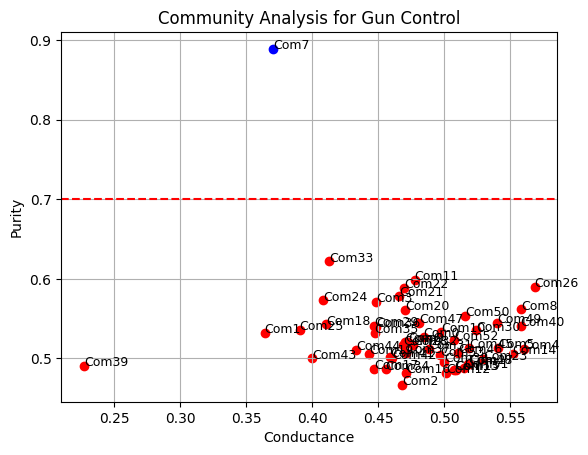



Percentage of users in echo chamber for Minorities Discrimination: 11.44%


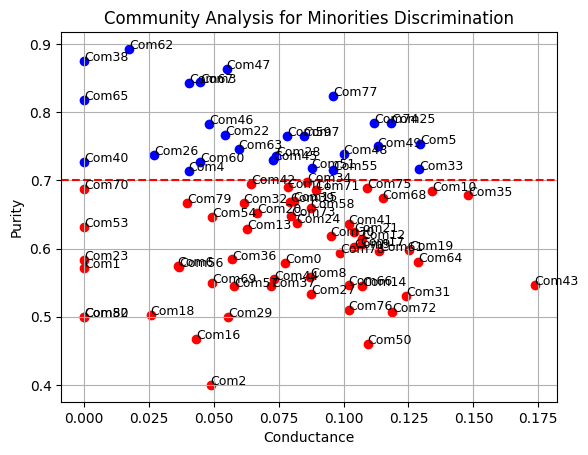

In [ ]:
def calculate_purity(network, communities):
    community_labels = {}
    for com_id, community in enumerate(communities):
        community_labels[com_id] = []
        for node in community:
            community_labels[com_id].append(network.nodes[node]['label'])

    purity_scores = {}
    for com_id, labels in community_labels.items():
        most_common = max(set(labels), key=labels.count)
        purity = labels.count(most_common) / len(labels)
        purity_scores[com_id] = purity
    return purity_scores

def calculate_conductance(network, partition):
    conductance_scores = {}
    for com_id in set(partition.values()):
        inner_edges = outer_edges = 0
        for node in network:
            if partition[node] == com_id:
                for neighbor in network.neighbors(node):
                    if partition[neighbor] == com_id:
                        inner_edges += 1
                    else:
                        outer_edges += 1
        total_edges = inner_edges + outer_edges
        conductance = outer_edges / total_edges if total_edges > 0 else 0
        conductance_scores[com_id] = conductance
    return conductance_scores

def analyze_and_plot(network, title):
    communities = detect_communities(network)  # Get list of communities

    # Create a node-to-community mapping (partition)
    partition = {}
    for com_id, community in enumerate(communities):
        for node in community:
            partition[node] = com_id

    # Handle nodes not assigned to any community
    for node in network.nodes():
        if node not in partition:
            partition[node] = -1  # Assign a special community ID for unassigned nodes

    purity_scores = calculate_purity(network, communities)
    conductance_scores = calculate_conductance(network, partition)

    echo_chamber_nodes = 0
    total_nodes = len(network.nodes())

    for com_id, purity in purity_scores.items():
        conductance = conductance_scores[com_id]
        if purity > 0.7 and conductance < 0.5:
            echo_chamber_nodes += len(communities[com_id])  # Sum members

    echo_chamber_percentage = (echo_chamber_nodes / total_nodes) * 100 if total_nodes > 0 else 0
    print(f"Percentage of users in echo chamber for {title}: {echo_chamber_percentage:.2f}%")

    plt.figure()
    for com_id in set(partition.values()):
        # Skip plotting for unassigned nodes
        if com_id == -1:
            continue

        pc = purity_scores[com_id]
        cc = conductance_scores[com_id]
        color = 'blue' if pc > 0.7 and cc < 0.5 else 'red'
        plt.scatter(cc, pc, color=color)
        plt.text(cc, pc, f'Com{com_id}', fontsize=9)

    plt.axhline(y=0.7, color='r', linestyle='--')
    plt.xlabel('Conductance')
    plt.ylabel('Purity')
    plt.title(f'Community Analysis for {title}')
    plt.grid(True)
    plt.show()

analyze_and_plot(guncontrol_network, "Gun Control")
print('\n')
analyze_and_plot(minority_network, "Minorities Discrimination")


The difference in results between the topics is stark.

GUN CONTROL (Figure above)
does not present strongly polarized communities. Indeed, on
average, only 0.13% of total users fall in an echo chamber.

As regards MINORITIES DISCRIMINATION (Figure below), the overall
scenario is definitely different. Indeed, on average, almost 12% of total users are trapped in echo chambers.